# Multi-label Classification
In this notebook we will be looking at an interesting dataset: [Planet's Understanding](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) the Amazon from Space. In order to get this data in to the shape we need it for modeling, We'll use the `DataBlock` API to load the data as a databunch. First we need to enter the competition and **aceppt the conditions** ( this is in the *rules* tab of the competition page) to be able to download the data from kaggle.

In [1]:
#Creating a data folder for the planet data
from fastai.vision import *
path   = Config.data_path()/'planet'           #get the config path of the fastai library and add planet
path.mkdir(exist_ok=True)                      #Create the directory if it doesnt exist
path

PosixPath('/home/anass/.fastai/data/planet')

## Listing the data

In [8]:
!kaggle competitions files -c planet-understanding-the-amazon-from-space

name                              size  creationDate         
-------------------------------  -----  -------------------  
train-jpg.tar.7z                 600MB  2017-04-20 00:13:50  
test-jpg.tar.7z                  603MB  2017-04-20 00:15:13  
train-tif-v2.tar.7z               13GB  2017-05-06 06:13:24  
test-tif-v2.tar.7z                19GB  2017-05-06 06:27:29  
test-jpg-additional.tar.7z       304MB  2017-05-06 06:49:41  
Kaggle-planet-test-tif.torrent     2MB  2017-05-06 06:54:37  
Kaggle-planet-train-tif.torrent    1MB  2017-05-06 06:54:55  
sample_submission_v2.csv.zip     154KB  2017-05-09 03:01:24  
train_v2.csv.zip                 159KB  2017-05-09 03:01:24  
test_v2_file_mapping.csv.zip     110KB  2017-06-08 00:26:28  


In [ ]:
#downloading the data
#!kaggle competitions download -c planet-understanding-the-amazon-from-space  -f train_v2.csv.zip -p {path}
#!kaggle competitions download -c planet-understanding-the-amazon-from-space  -f train-jpg.tar.7z -p {path}

In [2]:
#unziping the data
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [9]:
#! unzip path/'train_v2.csv.zip' -d path
!unzip {path}/train_v2.csv.zip -d {path}

Archive:  /home/anass/.fastai/data/planet/train_v2.csv.zip
  inflating: /home/anass/.fastai/data/planet/train_v2.csv  
   creating: /home/anass/.fastai/data/planet/__MACOSX/
  inflating: /home/anass/.fastai/data/planet/__MACOSX/._train_v2.csv  


In [10]:
path.ls()

[PosixPath('/home/anass/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/anass/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/home/anass/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/home/anass/.fastai/data/planet/train-jpg'),
 PosixPath('/home/anass/.fastai/data/planet/__MACOSX')]

Let's show the contents of the `train_v2.csv` file

In [13]:
import pandas as pd
df = pd.read_csv(path/"train_v2.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


We can see the file contain the name of the image and the set of labels associated with it. Now that we know the structure of the data, lets use  the `dabablock` API to create a databunch for this data.

In [34]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

data = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg' ,suffix='.jpg')      #Where to get the data
        .split_by_rand_pct()                                                             #validation by random splitting
        .label_from_df(label_delim=' ')                                                 #label from the second column of the dataframe (label are separated by space)
        .transform(tfms, size=128)                                                      #Transformation in tfms
        .databunch()                                                                    #convert into a databunch
       )

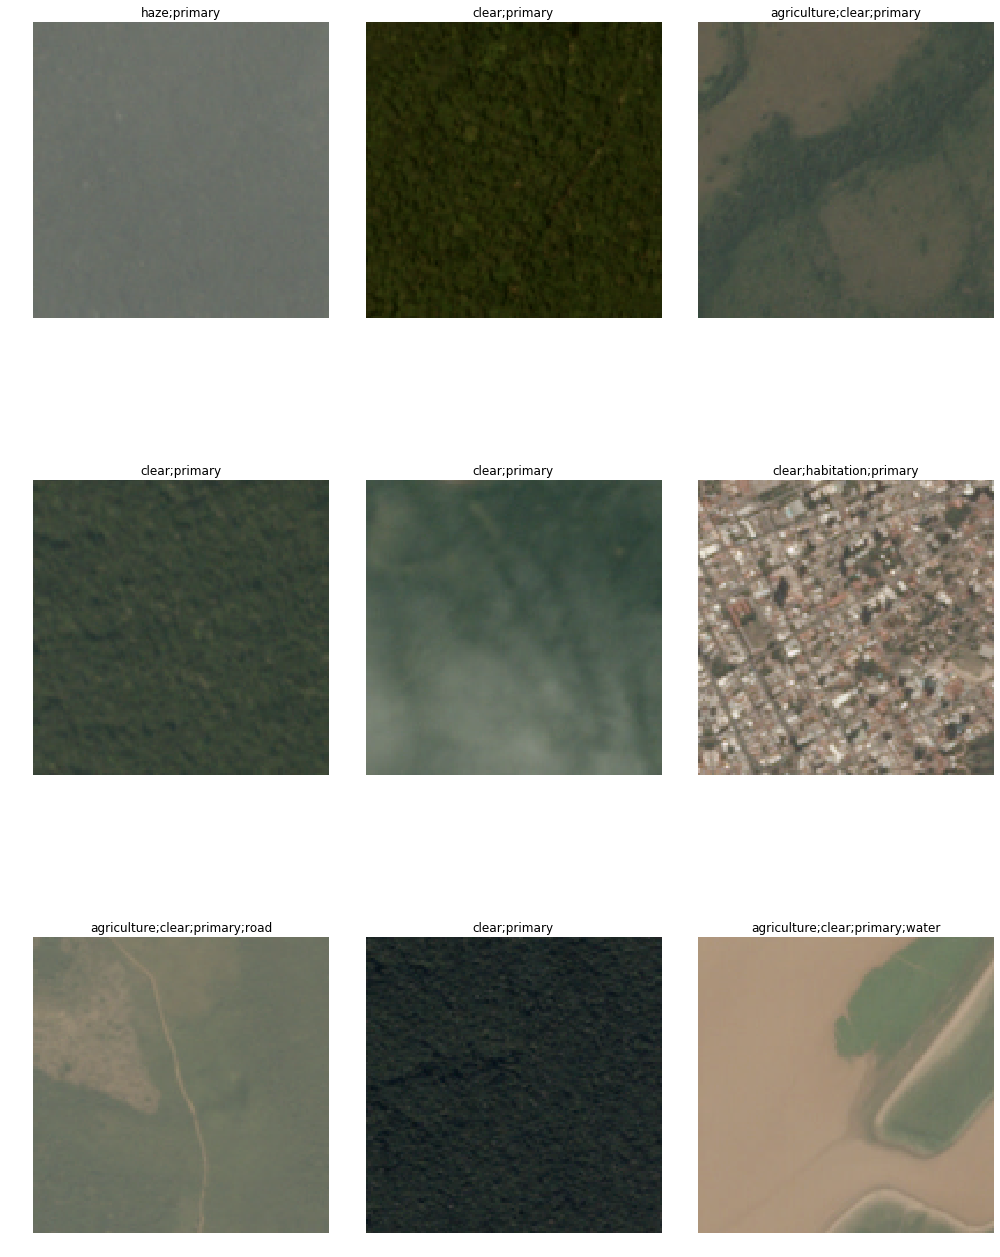

In [36]:
data.show_batch(3,figsize=(14,20))

## Creating a classifier


In [37]:
#Model based on Resnet
model = models.resnet50

In [51]:
#metrics
from functools import partial
accuracy = partial(accuracy_thresh, thresh=0.2)              #partial function accuracy(x) = accuracy_threshold(x,  threshold=0.2)
f_score   = partial(fbeta, thresh=0.2)

In [52]:
#Creating the learner
learn = create_cnn(data, model, metrics=[accuracy, f_score])

/home/anass/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [48]:
#learning rate
lr = 0.01

In [53]:
learn.fit_one_cycle(5, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124443,0.113331,0.946358,0.899382,01:29
1,0.110759,0.098158,0.946234,0.914071,01:28
2,0.103135,0.095511,0.955143,0.918070,01:29
3,0.095359,0.090313,0.954889,0.919768,01:29
4,0.087709,0.088405,0.954213,0.923057,01:25


In [54]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


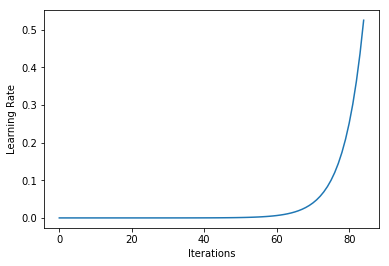

In [55]:
#fine tuning
learn.unfreeze()
learn.lr_find()

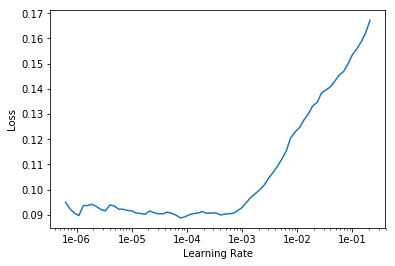

In [60]:
learn.recorder.plot(figsize=(20,30))

In [61]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091386,0.087296,0.957642,0.923899,01:54


In [62]:
learn.save('stage-2')

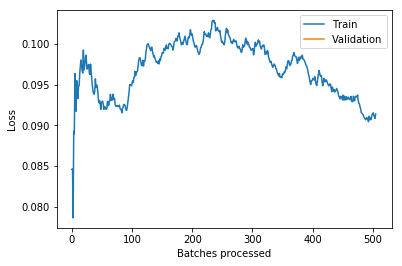

In [63]:
learn.recorder.plot_losses()